# Restricted Boltzmann Machine

Las **Máquinas Restringidas de Boltzmann (RBM)** son un tipo de red generativa que ha pesar de su simplicidad son de gran utilidad como estrategia de **reducción de dimensionalidad**. 

Este tipo de red neuronal consta de **2** capas, la primera capa (capa de entrada) se compone de tantas neuronas como variables de entrada. Esta capa es también llamada **capa visible**. Asimismo, las RBMs constan de una segunda capa, también conocida como **capa oculta**, la cual es en además la capa de salida de la neurona. Por lo tanto, tenemos una **matriz de pesos (W)** que es **compartida** por ambas capas, a la vez que cada una de estas posee su propio **bias**. Entonces, la función de costo consiste en **minimizar** la diferencia entre los datos **originales** y la **reconstrucción** de estos.

## Creando una RBM para MNIST

In [12]:
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np

### Conjunto de datos

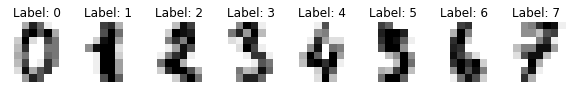

In [13]:
digits = datasets.load_digits()

def drawDataSet(X, y):
    _, axes = plt.subplots(nrows=1, ncols=8, figsize=(10, 3))
    for ax, image, label in zip(axes, X, y):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
        ax.set_title("Label: %i" % label)
        
drawDataSet(digits.images, digits.target)

In [14]:
print(f'Data shape: {digits.images.shape}, Target shape: {digits.target.shape}')

Data shape: (1797, 8, 8), Target shape: (1797,)


### Transformando los datos

In [15]:
X , y = digits.images, digits.target

In [16]:
X = X.reshape((-1,64))
X.shape

(1797, 64)

### Normalizando los datos

In [17]:
X /= 255.0

### Particionado de datos

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [20]:
print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')

X_train shape: (1347, 64), X_test shape: (450, 64)


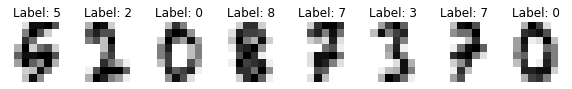

In [21]:
drawDataSet(X_train.reshape((-1,8,8)), y_train)

### Funciones de pérdida

In [22]:
def l2_cost(Yp, Yr):
    return np.mean((Yr - Yp) ** 2)

### Creando el modelo

Ya que RBMs son **grafos no dirigidos**, **no** ajustan su peso a traves del **descenso del gradiente** o **backpropagation**, sino que hacen uso de un proceso llamado **divergencia contrastiva**. 

In [23]:
first = X_train[0:1,:]
first.shape

(1, 64)

In [124]:
class RBM:
    def __init__(self, n_input_neurons, n_output_neurons):
        self.W = np.random.normal(loc=0.0, scale=1.0, size=(n_input_neurons, n_output_neurons)).astype(np.float32)
        self.visible_bias = np.random.rand(1, n_input_neurons) #visible layer bias
        self.hidden_bias = np.random.rand(1, n_output_neurons) #hidden layer bias
    
    def __sample(self, probability_distribution):
        random_dist = np.random.uniform(0, 1, probability_distribution.shape)
        example = probability_distribution - random_dist
        
        example[example > 0] = 1.0
        example[example <= 0] = 0.0
        return example
    
    def __sigmoid(self, x):
        return 1 / (1 + np.e ** (-x))
        
    def __encode(self, X):
        probability_distribution = self.__sigmoid(X @ self.W + self.hidden_bias) #probabilities of the hidden units
        return probability_distribution, self.__sample(probability_distribution)
        
    def __decode(self, X):
        probability_distribution = self.__sigmoid(X @ self.W.T + self.visible_bias) #probabilities of the visible units
        return probability_distribution, self.__sample(probability_distribution)
    
    def getReconstructedOutput(self, X):
        encode_probability, encode_sample = self.__encode(X)
        decode_probability, decode_sample = self.__decode(encode_sample)
        return decode_probability
        
    def train(self, X, loss_function, lr=.01, epochs=1000, verbose = False):
        epoch = 0
        history = []
        while epoch < epochs:
            h0_prob, h0_state = self.__encode(X)
            positive_associations = X.T.dot(h0_prob)
            
            v1_prob, v1_state = self.__decode(h0_state)
            h1_prob, h1_state = self.__encode(v1_state)
            
            negative_associations = v1_state.T.dot(h1_prob)

            delta_W = positive_associations - negative_associations
            self.W+= (lr * delta_W)
            
            self.hidden_bias+= (lr *  (h0_prob.sum(axis = 0) - h1_prob.sum(axis = 0)) )
            self.visible_bias+= (lr * (X.sum(axis=0) - v1_state.sum(axis=0)) )
            
            epoch+=1
            loss = loss_function(v1_state, X) #loss
            history.append(loss)
            if verbose:
                print(f'Epoch {epoch} ==> Loss: {loss}')
        return history

In [125]:
neural_net = RBM(64, 64)

Epoch 1 ==> Loss: 0.5565899811676567
Epoch 2 ==> Loss: 0.027061080706210022
Epoch 3 ==> Loss: 0.020115908427944598
Epoch 4 ==> Loss: 0.01338753964910418
Epoch 5 ==> Loss: 0.013214178730869029
Epoch 6 ==> Loss: 0.015252841263439594
Epoch 7 ==> Loss: 0.015318027880031296
Epoch 8 ==> Loss: 0.012707378943396505
Epoch 9 ==> Loss: 0.01788327818208233
Epoch 10 ==> Loss: 0.011392729104247781
Epoch 11 ==> Loss: 0.018891919389121936
Epoch 12 ==> Loss: 0.014688133197585189
Epoch 13 ==> Loss: 0.017379025812983243
Epoch 14 ==> Loss: 0.019332167871588424
Epoch 15 ==> Loss: 0.015225774943221825
Epoch 16 ==> Loss: 0.017923445511077774
Epoch 17 ==> Loss: 0.01799204384870533
Epoch 18 ==> Loss: 0.01833940253976898
Epoch 19 ==> Loss: 0.016034534787174252
Epoch 20 ==> Loss: 0.02251557653572223
Epoch 21 ==> Loss: 0.017895605867425213
Epoch 22 ==> Loss: 0.01702643581633128
Epoch 23 ==> Loss: 0.01725183685276664
Epoch 24 ==> Loss: 0.022799977601270942
Epoch 25 ==> Loss: 0.015688540784524935
Epoch 26 ==> Loss:

Epoch 205 ==> Loss: 0.019619798699717746
Epoch 206 ==> Loss: 0.01697726154380118
Epoch 207 ==> Loss: 0.020948595808761808
Epoch 208 ==> Loss: 0.017293687297473104
Epoch 209 ==> Loss: 0.01954555964997758
Epoch 210 ==> Loss: 0.018323253726865944
Epoch 211 ==> Loss: 0.019204069119095588
Epoch 212 ==> Loss: 0.019805032407157662
Epoch 213 ==> Loss: 0.0169741227604482
Epoch 214 ==> Loss: 0.020709002012817296
Epoch 215 ==> Loss: 0.017044813620311072
Epoch 216 ==> Loss: 0.020880224919203313
Epoch 217 ==> Loss: 0.017988359189986605
Epoch 218 ==> Loss: 0.01794800990253592
Epoch 219 ==> Loss: 0.019991858251080977
Epoch 220 ==> Loss: 0.01682600857787836
Epoch 221 ==> Loss: 0.021147112483434646
Epoch 222 ==> Loss: 0.016948603087100018
Epoch 223 ==> Loss: 0.02032884531019564
Epoch 224 ==> Loss: 0.017180327179855157
Epoch 225 ==> Loss: 0.019484558077856526
Epoch 226 ==> Loss: 0.0198407872436134
Epoch 227 ==> Loss: 0.01780776542315545
Epoch 228 ==> Loss: 0.018697451290078312
Epoch 229 ==> Loss: 0.0189

Epoch 413 ==> Loss: 0.01969444715598221
Epoch 414 ==> Loss: 0.016947556825982354
Epoch 415 ==> Loss: 0.020930308984009636
Epoch 416 ==> Loss: 0.018207437170102186
Epoch 417 ==> Loss: 0.018343314646556762
Epoch 418 ==> Loss: 0.0191301030070383
Epoch 419 ==> Loss: 0.018288545151527866
Epoch 420 ==> Loss: 0.019210483154642993
Epoch 421 ==> Loss: 0.020024383324956107
Epoch 422 ==> Loss: 0.017558527829082925
Epoch 423 ==> Loss: 0.018406272272071703
Epoch 424 ==> Loss: 0.02021503029643958
Epoch 425 ==> Loss: 0.018596828264327552
Epoch 426 ==> Loss: 0.01820361604254203
Epoch 427 ==> Loss: 0.018699953218837932
Epoch 428 ==> Loss: 0.02033371269887346
Epoch 429 ==> Loss: 0.01724023700124474
Epoch 430 ==> Loss: 0.01917923178995458
Epoch 431 ==> Loss: 0.018453399511980287
Epoch 432 ==> Loss: 0.01927275843595077
Epoch 433 ==> Loss: 0.019597417809722545
Epoch 434 ==> Loss: 0.016712193564122305
Epoch 435 ==> Loss: 0.02040672352904071
Epoch 436 ==> Loss: 0.01786012396865234
Epoch 437 ==> Loss: 0.02073

Epoch 617 ==> Loss: 0.019597599768177792
Epoch 618 ==> Loss: 0.019550154100972533
Epoch 619 ==> Loss: 0.01811099918882208
Epoch 620 ==> Loss: 0.018920259418526424
Epoch 621 ==> Loss: 0.018224905181805754
Epoch 622 ==> Loss: 0.01790843393852002
Epoch 623 ==> Loss: 0.021106353789459655
Epoch 624 ==> Loss: 0.018039307557455343
Epoch 625 ==> Loss: 0.01872406271415797
Epoch 626 ==> Loss: 0.019766457214645615
Epoch 627 ==> Loss: 0.01737356705932588
Epoch 628 ==> Loss: 0.019647683832984115
Epoch 629 ==> Loss: 0.01844352826578322
Epoch 630 ==> Loss: 0.019337990542156274
Epoch 631 ==> Loss: 0.017784065334359722
Epoch 632 ==> Loss: 0.019878179706166354
Epoch 633 ==> Loss: 0.01809744328390628
Epoch 634 ==> Loss: 0.019165175499286865
Epoch 635 ==> Loss: 0.018842199241226106
Epoch 636 ==> Loss: 0.019342403034695983
Epoch 637 ==> Loss: 0.01719906890074544
Epoch 638 ==> Loss: 0.020798252635115214
Epoch 639 ==> Loss: 0.01775618020109335
Epoch 640 ==> Loss: 0.01906800968418577
Epoch 641 ==> Loss: 0.018

Epoch 820 ==> Loss: 0.022046169210802654
Epoch 821 ==> Loss: 0.017061508308579845
Epoch 822 ==> Loss: 0.019201339742266905
Epoch 823 ==> Loss: 0.018639315563627377
Epoch 824 ==> Loss: 0.0197164186394531
Epoch 825 ==> Loss: 0.0175564353068476
Epoch 826 ==> Loss: 0.019810036264676912
Epoch 827 ==> Loss: 0.018309060967356797
Epoch 828 ==> Loss: 0.018802122891458283
Epoch 829 ==> Loss: 0.01818701233350088
Epoch 830 ==> Loss: 0.018527638561720454
Epoch 831 ==> Loss: 0.019509440896611344
Epoch 832 ==> Loss: 0.019213303510699296
Epoch 833 ==> Loss: 0.018350047109400844
Epoch 834 ==> Loss: 0.01972497068684964
Epoch 835 ==> Loss: 0.01896274671782625
Epoch 836 ==> Loss: 0.01738721394346929
Epoch 837 ==> Loss: 0.020612518541923374
Epoch 838 ==> Loss: 0.01674494608606649
Epoch 839 ==> Loss: 0.0220807413172993
Epoch 840 ==> Loss: 0.01509053432136061
Epoch 841 ==> Loss: 0.020733839341958306
Epoch 842 ==> Loss: 0.019176229475443028
Epoch 843 ==> Loss: 0.01670268623483572
Epoch 844 ==> Loss: 0.0198731

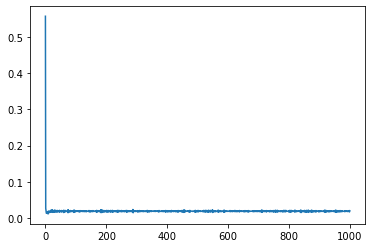

In [126]:
history = neural_net.train(X_train, l2_cost, verbose = True)
plt.plot(history)

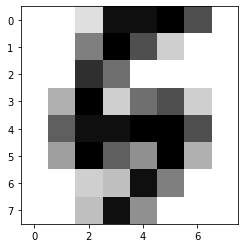

In [127]:
test = X_train[:1,:]
plt.imshow(test.reshape((1,8,8))[0], cmap=plt.cm.gray_r, interpolation="nearest")

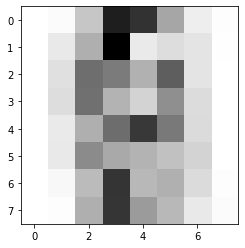

In [128]:
reconstructed = neural_net.getReconstructedOutput(test)

plt.imshow(reconstructed.reshape((1,8,8))[0], cmap=plt.cm.gray_r, interpolation="nearest")